In [95]:
# Importar las librerías necesarias
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import pandas as pd
import nbformat
import unicodedata


In [96]:
# Transformacion de los datos Municipios y generar dataset
# Cargar el archivo CSV
municipios_df = pd.read_csv('municipios/Municipios_Chip.csv')

# Se crea una nueva columna con el formato "IdEntidad - Municipio"
municipios_df['Entidad_Municipio'] = municipios_df['IdEntidad'].astype(str) + ' - ' + municipios_df['RazónSocial']

# Mostrar el dataframe resultante
municipios = (municipios_df[['Entidad_Municipio']])
municipiosid = (municipios_df[['IdEntidad']])
# print("Municipios", municipios)
# print("IdEntidad", municipiosid)

In [ ]:
# Definir la ruta de destino
destination_dir = "/Users/cesar/Documents/Importacion/activos"

# Configurar el driver de Chrome
driver = webdriver.Chrome()

# Configurar la carpeta de descargas
download_dir = "/Users/cesar/Downloads"  # Ruta de la carpeta de descargas por defecto

# Lista para almacenar los municipios que no pudieron procesarse
municipios_no_procesados = []



# Función para hacer clic en un elemento con reintentos
def click_element(driver, by, value, retries=3):
    for attempt in range(retries):
        try:
            element = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((by, value))
            )
            element.click()
            return
        except (StaleElementReferenceException, TimeoutException):
            if attempt < retries - 1:
                time.sleep(1)
            else:
                raise

# Función para enviar texto a un elemento con reintentos
def send_keys_element(driver, by, value, keys, retries=3):
    for attempt in range(retries):
        try:
            element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((by, value))
            )
            element.send_keys(keys)
            return
        except (StaleElementReferenceException, TimeoutException):
            if attempt < retries - 1:
                time.sleep(1)
            else:
                raise

# Función para sanitizar el nombre del municipio
def sanitize_filename(filename):
    filename = unicodedata.normalize('NFKD', filename).encode('ascii', 'ignore').decode('ascii')
    return filename

# Iterar sobre cada municipio en el dataframe
for index, row in municipios.iterrows():
    municipio = row['Entidad_Municipio']
    sanitized_municipio = sanitize_filename(municipio)
    expected_filename = f"{sanitized_municipio}.xls"
    
    # Verificar si el archivo ya existe en la carpeta de destino
    if any(sanitize_filename(f).replace('.xls', '') == sanitized_municipio for f in os.listdir(destination_dir) if f.endswith('.xls')):
        print(f"El archivo {expected_filename} ya existe. Saltando descarga.")
        continue
    
    # Intentar procesar el municipio hasta 2 veces
    for attempt in range(2):
        try:
            # Acceder a la página
            driver.get("https://www.chip.gov.co/schip_rt/index.jsf")

            # Esperar a que la página esté completamente cargada
            WebDriverWait(driver, 10).until(
                lambda d: d.execute_script('return document.readyState') == 'complete'
            )

            # Navegar a la sección "Consultas"
            click_element(driver, By.LINK_TEXT, "Consultas")

            # Navegar a "Informe al Ciudadano"
            click_element(driver, By.LINK_TEXT, "Informe al Ciudadano")

            # Buscar el ID del municipio
            send_keys_element(driver, By.CSS_SELECTOR, "#frm1\\:SelBoxEntidadCiudadano input[id='frm1:SelBoxEntidadCiudadano_input']", municipio)
            send_keys_element(driver, By.CSS_SELECTOR, "#frm1\\:SelBoxEntidadCiudadano input[id='frm1:SelBoxEntidadCiudadano_input']", Keys.RETURN)
            time.sleep(1)
            
            # Seleccionar la categoría "FUT_GASTOS_DE_INVERSION" del select con el ID "frm1:SelBoxCategoria"
            categoria_select = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "#frm1\\:SelBoxCategoria"))
            )
            select = Select(categoria_select)
            
            for option in select.options:
                if option.text == "FUT_GASTOS_DE_INVERSION":
                    option.click()
                    break

            time.sleep(1)
            # Seleccionar el periodo "OCT A DIC - 2009" del select con el ID "frm1:SelBoxPeriodo"
            periodo_select = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "#frm1\\:SelBoxPeriodo"))
            )
            select = Select(periodo_select)
            
            for option in select.options:
                if option.text == "OCT A DIC - 2009":
                    option.click()
                    break

            time.sleep(1)
            # Seleccionar Formulario "GASTOS_DE_INVERSION" del select con el ID "frm1:SelBoxForma"
            forma_select = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "#frm1\\:SelBoxForma"))
            )
            select = Select(forma_select)
            
            for option in select.options:
                if option.text == "GASTOS_DE_INVERSION":
                    option.click()
                    break

            time.sleep(1)
            # Hacer clic en el botón "Consultar"
            click_element(driver, By.ID, "frm1:BtnConsular")

            time.sleep(1)

            # Hacer clic en la imagen para descargar el archivo
            click_element(driver, By.CSS_SELECTOR, "a[title='Descargar a Excel'] img")

            time.sleep(1)

            # Renombrar y mover el archivo descargado
            for filename in os.listdir(download_dir):
                if filename.endswith(".xls"):  # Ajusta la extensión según el tipo de archivo descargado
                    source_path = os.path.join(download_dir, filename)
                    destination_path = os.path.join(destination_dir, f"{sanitized_municipio}.xls")
                    os.rename(source_path, destination_path)
                    break

            time.sleep(1)
            break  # Salir del bucle de reintento si se procesa correctamente

        except Exception as e:
            print(f"Error al procesar el municipio {municipio} en el intento {attempt + 1}: {e}")
            print(f"Detalles del error: {e.__class__.__name__}: {e}")
            if attempt == 1:  # Si es el último intento, agregar a la lista de no procesados
                municipios_no_procesados.append(municipio)

# Guardar los municipios que no pudieron procesarse en un archivo CSV
if municipios_no_procesados:
    df_no_procesados = pd.DataFrame(municipios_no_procesados, columns=['Municipio'])
    df_no_procesados.to_csv('no_procesado/municipios_no_procesados.csv', index=False)
# Cerrar el navegador
driver.quit()
print("Script finalizado correctamente.")

In [ ]:
print(df_no_procesados)

In [ ]:
import os
import time
import pandas as pd
import unicodedata
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException

# Función para hacer clic en un elemento con reintentos
def click_element(driver, by, value, retries=3):
    for attempt in range(retries):
        try:
            element = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((by, value))
            )
            element.click()
            return
        except (StaleElementReferenceException, TimeoutException):
            if attempt < retries - 1:
                time.sleep(1)
            else:
                raise

# Función para enviar texto a un elemento con reintentos
def send_keys_element(driver, by, value, keys, retries=3):
    for attempt in range(retries):
        try:
            element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((by, value))
            )
            element.send_keys(keys)
            return
        except (StaleElementReferenceException, TimeoutException):
            if attempt < retries - 1:
                time.sleep(1)
            else:
                raise

# Función para sanitizar el nombre del municipio
def sanitize_filename(filename):
    filename = unicodedata.normalize('NFKD', filename).encode('ascii', 'ignore').decode('ascii')
    return filename

# Leer el archivo CSV
municipios_no_procesados_df = pd.read_csv('no_procesado/municipios_no_procesados.csv')

# Mostrar el contenido del archivo
print(municipios_no_procesados_df)

destination_dir = "/Users/cesar/Documents/Importacion/activos"
# Configurar el driver de Chrome
driver = webdriver.Chrome()

# Configurar la carpeta de descargas
download_dir = "/Users/cesar/Downloads"  # Ruta de la carpeta de descargas por defecto

# Crear una lista para almacenar los municipios no procesados y sus razones
municipios_no_procesados = []

# Iterar sobre cada municipio en el dataframe de no procesados
for index, row in municipios_no_procesados_df.iterrows():
    municipio = row['Municipio']
    sanitized_municipio = sanitize_filename(municipio)
    expected_filename = f"{sanitized_municipio}.xls"
    
    # Verificar si el archivo ya existe
    if any(sanitize_filename(f).replace('.xls', '') == sanitized_municipio for f in os.listdir(destination_dir) if f.endswith('.xls')):
        print(f"El archivo {expected_filename} ya existe. Saltando descarga.")
        continue
    
    # Intentar procesar el municipio hasta 2 veces
    for attempt in range(2):
        try:
            # Acceder a la página
            driver.get("https://www.chip.gov.co/schip_rt/index.jsf")

            # Esperar a que la página esté completamente cargada
            WebDriverWait(driver, 10).until(
                lambda d: d.execute_script('return document.readyState') == 'complete'
            )

            # Navegar a la sección "Consultas"
            click_element(driver, By.LINK_TEXT, "Consultas")

            # Navegar a "Informe al Ciudadano"
            click_element(driver, By.LINK_TEXT, "Informe al Ciudadano")

            # Buscar el ID del municipio
            send_keys_element(driver, By.CSS_SELECTOR, "#frm1\\:SelBoxEntidadCiudadano input[id='frm1:SelBoxEntidadCiudadano_input']", municipio)
            send_keys_element(driver, By.CSS_SELECTOR, "#frm1\\:SelBoxEntidadCiudadano input[id='frm1:SelBoxEntidadCiudadano_input']", Keys.RETURN)
            time.sleep(1)
            
            # Seleccionar la categoría "FUT_GASTOS_DE_INVERSION" del select con el ID "frm1:SelBoxCategoria"
            categoria_select = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "#frm1\\:SelBoxCategoria"))
            )
            select = Select(categoria_select)
            
            categoria_encontrada = False
            for option in select.options:
                if option.text == "FUT_GASTOS_DE_INVERSION":
                    option.click()
                    categoria_encontrada = True
                    break

            if not categoria_encontrada:
                raise ValueError("Categoría no encontrada")

            time.sleep(1)
            # Seleccionar el periodo "OCT A DIC - 2009" del select con el ID "frm1:SelBoxPeriodo"
            periodo_select = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "#frm1\\:SelBoxPeriodo"))
            )
            select = Select(periodo_select)
            
            periodo_encontrado = False
            for option in select.options:
                if option.text == "OCT A DIC - 2009":
                    option.click()
                    periodo_encontrado = True
                    break

            if not periodo_encontrado:
                raise ValueError("Periodo no encontrado")

            time.sleep(1)
            # Seleccionar Formulario "GASTOS_DE_INVERSION" del select con el ID "frm1:SelBoxForma"
            forma_select = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "#frm1\\:SelBoxForma"))
            )
            select = Select(forma_select)
            
            for option in select.options:
                if option.text == "GASTOS_DE_INVERSION":
                    option.click()
                    break

            time.sleep(1)
            # Hacer clic en el botón "Consultar"
            click_element(driver, By.ID, "frm1:BtnConsular")

            time.sleep(1)

            # Hacer clic en la imagen para descargar el archivo
            click_element(driver, By.CSS_SELECTOR, "a[title='Descargar a Excel'] img")

            # Extraer el texto del span
            span_text = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "frm1:j_idt152"))
            ).text

            time.sleep(1)

            # Renombrar y mover el archivo descargado
            for filename in os.listdir(download_dir):
                if filename.endswith(".xls"):  # Ajusta la extensión según el tipo de archivo descargado
                    source_path = os.path.join(download_dir, filename)
                    destination_path = os.path.join(destination_dir, f"{sanitized_municipio}.xls")
                    os.rename(source_path, destination_path)
                    break

            time.sleep(1)
            break  # Salir del bucle de reintento si se procesa correctamente

        except Exception as e:
            print(f"Error al procesar el municipio {municipio} en el intento {attempt + 1}: {e}")
            print(f"Detalles del error: {e.__class__.__name__}: {e}")
            if attempt == 1:  # Si es el último intento, agregar a la lista de no procesados
                if "Categoría no encontrada" in str(e):
                    razon = "Categoría no encontrada"
                elif "Periodo no encontrado" in str(e):
                    razon = "Periodo OCT A DIC - 2009 no encontrado"
                else:
                    razon = "Sin Categoria, ni periodo"
                municipios_no_procesados.append({"Municipio": municipio, "Razon": razon})

# Guardar los municipios que no pudieron procesarse en un archivo CSV
if municipios_no_procesados:
    df_no_procesados = pd.DataFrame(municipios_no_procesados)
    df_no_procesados.to_csv('no_procesado/municipios_no_procesados_detalle.csv', index=False)

# Cerrar el navegador
driver.quit()
print("Script finalizado correctamente.")


                                    Razon  Cantidad
0  Periodo OCT A DIC - 2009 no encontrado       123
1                 Categoría no encontrada        24
2               Sin Categoria, ni periodo         1


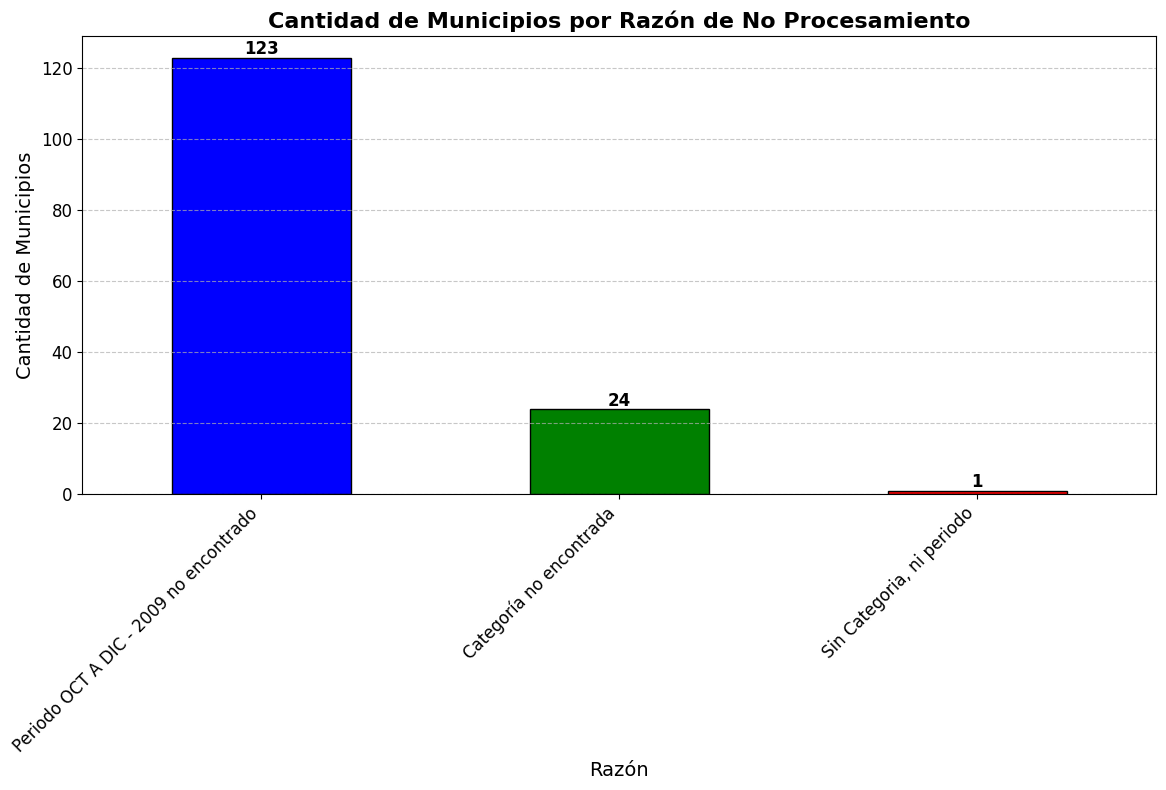

In [115]:
import matplotlib.pyplot as plt
df_no_procesados
# Organizar los municipios según la razón
df_no_procesados_sorted = df_no_procesados.sort_values(by='Razon')
# Crear una gráfica de barras para visualizar las razones

# Contar la cantidad de municipios por cada razón
razon_counts = df_no_procesados_sorted['Razon'].value_counts()
# Crear una tabla resumen
tabla_resumen = razon_counts.reset_index()
tabla_resumen.columns = ['Razon', 'Cantidad']
print(tabla_resumen)
# Crear la gráfica
plt.figure(figsize=(12, 8))
colors = {'Periodo OCT A DIC - 2009 no encontrado': 'blue', 'Sin Categoria, ni periodo': 'red', 'Categoría no encontrada': 'green'}
bars = razon_counts.plot(kind='bar', color=[colors[razon] for razon in razon_counts.index], edgecolor='black')

# Personalizar la gráfica
plt.title('Cantidad de Municipios por Razón de No Procesamiento', fontsize=16, fontweight='bold')
plt.xlabel('Razón', fontsize=14)
plt.ylabel('Cantidad de Municipios', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de cantidad encima de cada barra
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, str(int(bar.get_height())), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()